 # Part 5: Creative Adversarial Networks

Setting up environment and helper functions

In [1]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import IPython.display
import numpy as np
import PIL.Image
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
def imgrid(imarray, cols=5, pad=1):
    if isinstance(imarray, np.ndarray):
        N, H, W, C = imarray.shape
    if isinstance(imarray, list):
        N = len(imarray)
    rows = N // cols + int(N % cols != 0)
    for i in range(N):
        plt.subplot(rows, cols, i+1)
        plt.title("%d"%i)
        plt.imshow(imarray[i])
        plt.axis('off')

Downloading the model

In [ ]:
import gdown
gdown.download('https://drive.google.com/uc?id=1E06vaWs3b-JkPyn5Itr4RRKst67-8CAw',None,False)

In [ ]:
!unzip external_can_9_epochs.zip

Reading the checkpoint and weights from the meta graph

In [3]:
tf.reset_default_graph()

In [4]:
sess = tf.Session()
new_saver = tf.train.import_meta_graph('checkpoint/DCGAN.model-45502.meta', clear_devices=True)
initializer = tf.global_variables_initializer()
sess.run(initializer)
new_saver.restore(sess, 'checkpoint/DCGAN.model-45502')

W1018 17:01:16.710824 11060 deprecation.py:323] From D:\Home\Software\envs\tf_gpu\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [13]:
[p for p in sess.graph.get_operations() if p.type == 'Placeholder']
#[p for p in sess.graph.get_operations() if 'generator_1' in p.name]

[<tf.Operation 'y' type=Placeholder>,
 <tf.Operation 'real_images' type=Placeholder>,
 <tf.Operation 'z' type=Placeholder>]

In [28]:
generator_output = tf.get_default_graph().get_tensor_by_name("generator/Tanh:0")

In [29]:
BATCH_SIZE = 10

In [30]:
# generate some noise
z_sample = np.random.normal(0, 1, size=(BATCH_SIZE, 100))
z_sample /= np.linalg.norm(z_sample, axis=0)

# generate class labels (there are 27 classes of paintings)
y = np.random.choice(27, BATCH_SIZE)
y_one_hot = np.zeros((BATCH_SIZE, 27))
y_one_hot[np.arange(1), y] = 1

In [31]:
image = sess.run(generator_output, feed_dict={'z:0': z_sample, 'y:0': y_one_hot})

In [12]:
image.min(),image.max(),image.shape,y

(-1.0, 1.0, (10, 256, 256, 3), array([23,  3,  9,  1, 23, 14,  0,  3, 21, 25]))

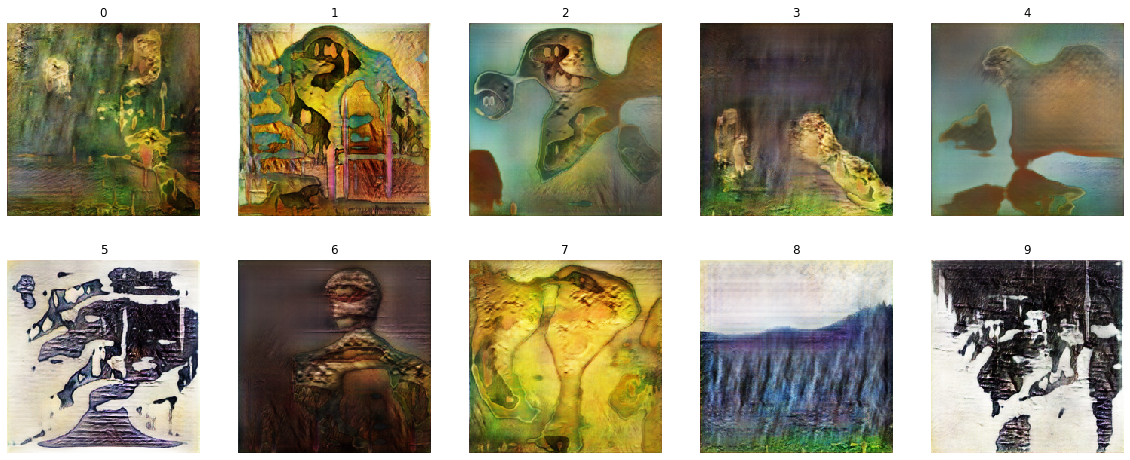

In [32]:
plt.figure(figsize=(20,8))
imgrid((image + 1.0)/2.0)

In [47]:
BATCH_SIZE = 10

# generate some noise
z_sample = np.random.normal(0, 1, size=(BATCH_SIZE, 100))
z_sample /= np.linalg.norm(z_sample, axis=0)

# generate class labels (there are 27 classes of paintings)
y = np.random.choice(27, 1)
y_one_hot = np.zeros((1, 27))
y_one_hot[np.arange(1), y] = 1
y_one_hot_samples = np.repeat(y_one_hot, BATCH_SIZE, axis=0)

# Task1:
## Pick a single label and generate many samples from different seed noise

In [48]:
# Getting the same one hot label for all samples
y_one_hot_samples

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],


In [49]:
image = sess.run(generator_output, feed_dict={'z:0': z_sample, 'y:0': y_one_hot})

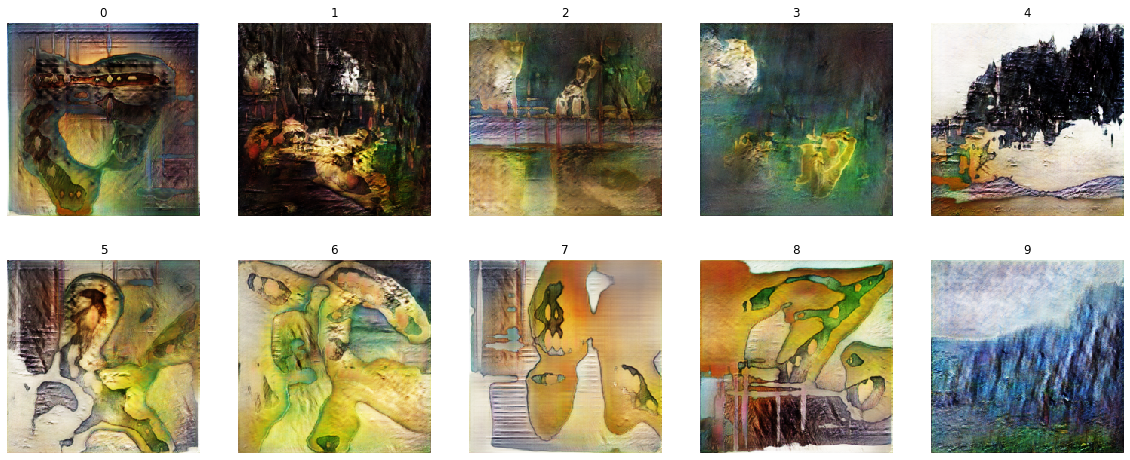

In [50]:
plt.figure(figsize=(20,8))
imgrid((image + 1.0)/2.0)

# Task2:
## Pick a single image and repeat it with different amounts of noise added to latent vector

W1018 17:09:49.668793 11060 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


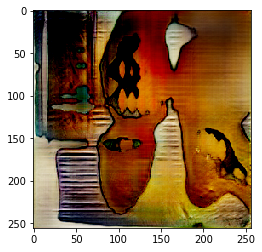

In [52]:
plt.imshow(image[7]);

In [65]:
chosen_img = image[7]
chosen_z = np.asarray([z_sample[7]])

In [89]:
z_noisy = np.repeat(chosen_z, 10, axis=0) + 0.08 * np.random.normal(0,1, [10, 100])

In [90]:
image = sess.run(generator_output, feed_dict={'z:0': z_noisy, 'y:0': y_one_hot})

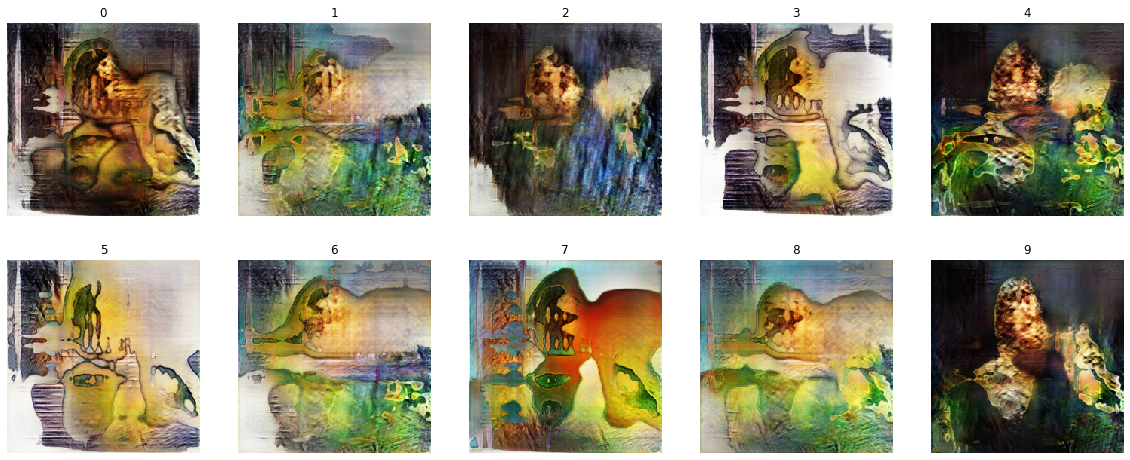

In [91]:
plt.figure(figsize=(20,8))
imgrid((image + 1.0)/2.0)

## Testing: Add no noise to check you are starting with the same seed

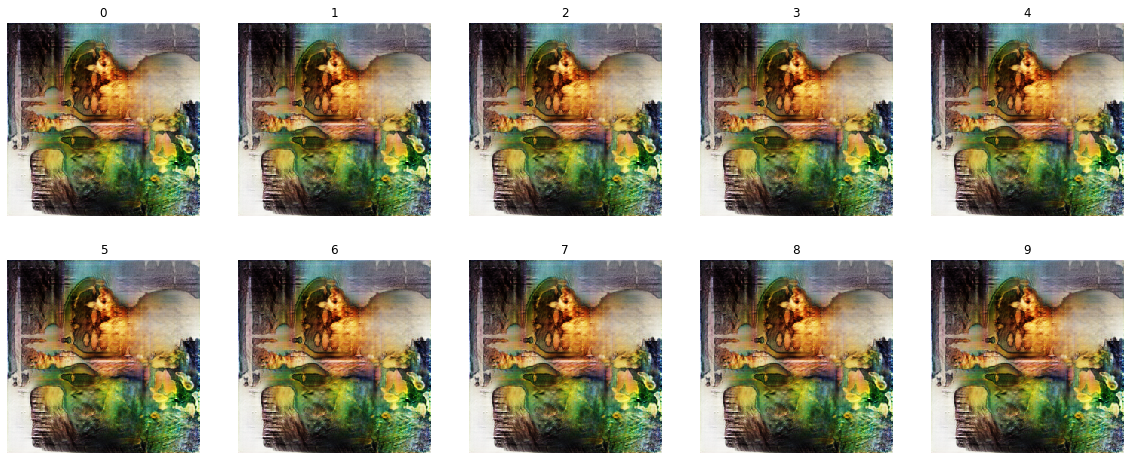

In [93]:
# TESTING
z_noisy = np.repeat(chosen_z, 10, axis=0) + 0 * np.random.normal(0,1, [10, 100])
image = sess.run(generator_output, feed_dict={'z:0': z_noisy, 'y:0': y_one_hot})
plt.figure(figsize=(20,8))
imgrid((image + 1.0)/2.0)

## Adding a decent amount of gaussian noise to explore the different directions along each class latent space

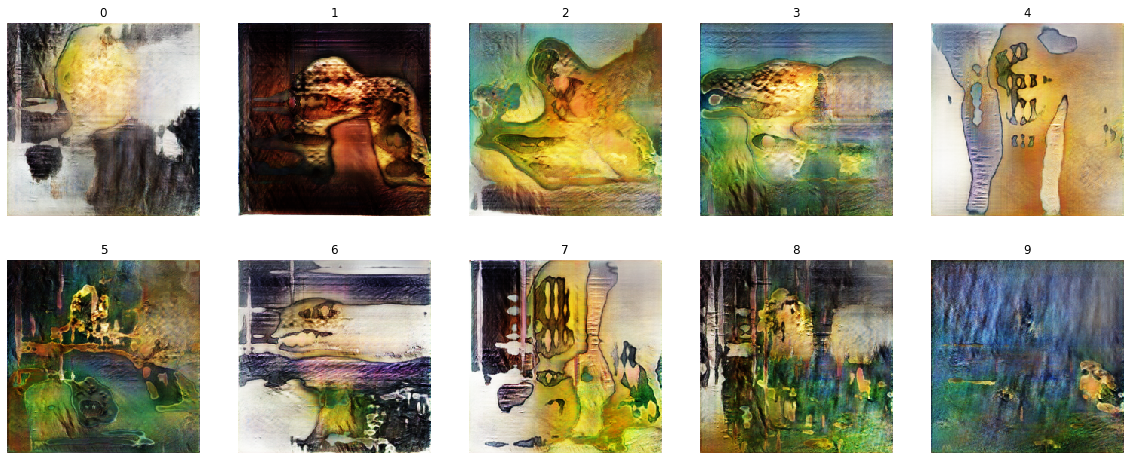

In [96]:
z_noisy = np.repeat(chosen_z, 10, axis=0) + 0.2* np.random.normal(0,1, [10, 100])
image = sess.run(generator_output, feed_dict={'z:0': z_noisy, 'y:0': y_one_hot})
plt.figure(figsize=(20,8))
imgrid((image + 1.0)/2.0)